
# **Bakery** **Market** **Basket** **Analysis**
In food market finding a new way to increase sales and customer engagement are 

* The most common and difficult task to deal. Increase the number of competitors, economy, seazonal issues and a lot of others features that influence in this market.

* To have advatange it is very important to understand the customer behavior, store layout and do customized offers to this customer.

* Thinking about that Machine Learning can help to understand the customer behavior and analyze the sales history to make predictions to boost the sales. And one option to do that is using Market Basket Analysis, that is a method to understand the combination of items that estimulate more sales. 



**Doing EDA will help to understand the dataset and which features to select to find the label of prediction**

The dataset consists of 21293 observations from a bakery. The data file contains four variables, Date, Time, Transaction ID and Item. Transaction ID ranges from 1 through 9684. However, there are some skipped numbers in Transaction IDs. Also, there are duplicated entries, as shown in observation # 2 and #3. Besides, the Item contains "Adjustment", "NONE", and "Afternoon with the baker". While the entries of "Adjustment" and "NONE" are straight forward, "Afternoon with the baker" may be a real purchase.

***Import Libraries***

In [ ]:
# Importation of libraries
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Read in and examine the data set


from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

print(f'Libraries loaded!')


Libraries loaded!


**Load file & Data preparation**

In [ ]:
# Open and Creating the dataset
df_initial = pd.read_csv('/BreadBasket_DMS.csv', header = 0)
df_initial.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


**Identifying Features & Labels**

In [ ]:
# Dataset info
display(df_initial.info())

# Descriptive statistics of the data
display(df_initial.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


None

,Transaction
count,21293.000000
mean,4951.990889
std,2787.758400
min,1.000000
25%,2548.000000
50%,5067.000000
75%,7329.000000
max,9684.000000


# ***Data Cleaning and Manipulation***

In [ ]:
#Missing Value Identification

# Identify null values on dataset
print('  ' * 10 + " Display information about column types and number of null values " + '  ' * 10 )
print('--' * 50)

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))

if(any(df_initial.isnull().any())):
    print()
    display(tab_info)
else:
    print('NO missing data')

                     Display information about column types and number of null values                     
----------------------------------------------------------------------------------------------------
NO missing data


In [ ]:
#Let's check the 'hidden' missing values in the dataset
missing_value = ["NaN", "NONE", "None", "Nil", "nan", "none", "nil", 0]

print('---------------------------------------------------------')
print("There are {0} 'hidden' missing values in the 'Item'column.".format(len(df_initial[df_initial.Item.isin(missing_value)])))
print("There are {0} 'hidden' missing values in the 'Transaction'.".format(len(df_initial[df_initial.Transaction.isin(missing_value)])))
print('---------------------------------------------------------')
df_initial[df_initial.Item.isin(missing_value)].head()

---------------------------------------------------------
There are 786 'hidden' missing values in the 'Item'column.
There are 0 'hidden' missing values in the 'Transaction'.
---------------------------------------------------------


,Date,Time,Transaction,Item
26,2016-10-30,10:27:21,11,NONE
38,2016-10-30,10:34:36,15,NONE
39,2016-10-30,10:34:36,15,NONE
66,2016-10-30,11:05:30,29,NONE
80,2016-10-30,11:37:10,37,NONE


**Drop the missing values**

In [ ]:
# Selecting the row values to drop in the selected column
bread = df_initial.drop(df_initial[df_initial.Item == "NONE"].index)
print("Number of rows: {0:,} (original 21,293) ".format(len(bread)))
print('----------------------------------------')
bread.head()

# After removing the missing values, the number of rows left is 20,507 (original 21,293 minus 786 missing)

Number of rows: 20,507 (original 21,293) 
----------------------------------------


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


**Dataset transformation**

In [ ]:
# Creating a column of DateTimeIndex
bread['Datetime'] = pd.to_datetime(bread['Date'] + ' ' + bread['Time'])
bread = bread[["Datetime", "Transaction", "Item"]].set_index("Datetime")
bread.head()

,Transaction,Item
Datetime,,
2016-10-30 09:58:11,1,Bread
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:07:57,3,Hot chocolate
2016-10-30 10:07:57,3,Jam




Extract hour and days of week


In [ ]:
# Extract hour of the day and weekday of the week
# For Datetimeindex: the day of the week are Monday=0, Sunday=6, thereby +1 to become Monday=1, Sunday=7
bread["Hour"] = bread.index.hour
bread["Weekday"] = bread.index.weekday + 1

bread.head()

,Transaction,Item,Hour,Weekday
Datetime,,,,
2016-10-30 09:58:11,1,Bread,9,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:07:57,3,Hot chocolate,10,7
2016-10-30 10:07:57,3,Jam,10,7


Exploring data attributes

In [ ]:
total_items = len(bread)
total_days = len(np.unique(bread.index.date))
total_months = len(np.unique(bread.index.month))
average_items = int(total_items / total_days)
unique_items = bread.Item.unique().size

print("Total unique_items: {} sold by the Bakery".format(unique_items))
print('-----------------------------')
print("Total sales: {} items sold in {} days throughout {} months".format(total_items, total_days, total_months))
print('-----------------------------')
print("Average_items daily sales: {}".format(average_items))

Total unique_items: 94 sold by the Bakery
-----------------------------
Total sales: 20507 items sold in 159 days throughout 7 months
-----------------------------
Average_items daily sales: 128


**top 10 best-selling items**

In [ ]:
# Rank the top 10 best-selling items
counts = bread.Item.value_counts()
percent = bread.Item.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
top_10 = pd.DataFrame({'counts': counts, '%': percent})[:10]

print('-----------------------------')
print('Top 10 items')
print('-----------------------------')
display(top_10)

-----------------------------
Top 10 items
-----------------------------


,counts,%
Coffee,5471,26.7%
Bread,3325,16.2%
Tea,1435,7.0%
Cake,1025,5.0%
Pastry,856,4.2%
Sandwich,771,3.8%
Medialuna,616,3.0%
Hot chocolate,590,2.9%
Cookies,540,2.6%
Brownie,379,1.8%


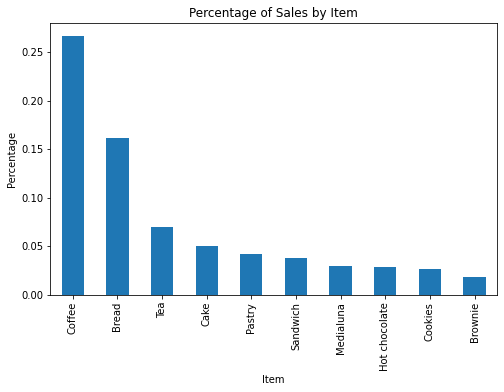

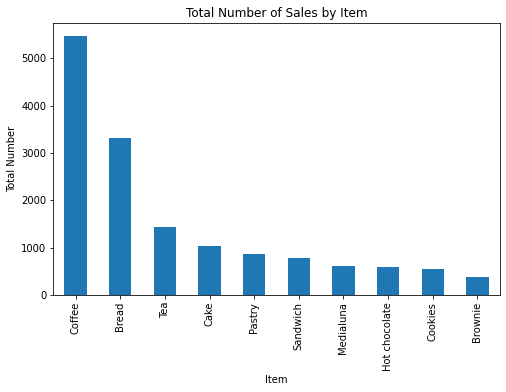

In [ ]:
# Rank by percentage
plt.figure(figsize=(8,5))
bread.Item.value_counts(normalize=True)[:10].plot(kind="bar", title="Percentage of Sales by Item").set(xlabel="Item", ylabel="Percentage")
plt.show()

# Rank by value
plt.figure(figsize=(8,5))
bread.Item.value_counts()[:10].plot(kind="bar", title="Total Number of Sales by Item").set(xlabel="Item", ylabel="Total Number")
plt.show()

**Time Series**

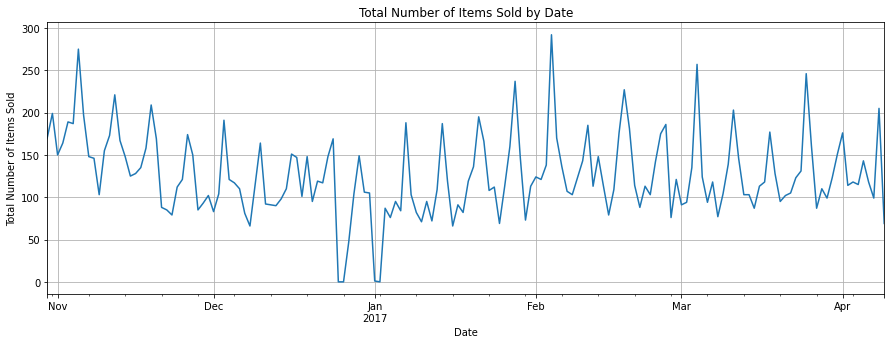

In [ ]:
# Number of items sold by day
bread["Item"].resample("D").count().plot(figsize=(15,5), grid=True, title="Total Number of Items Sold by Date").set(xlabel="Date", ylabel="Total Number of Items Sold")
plt.show()

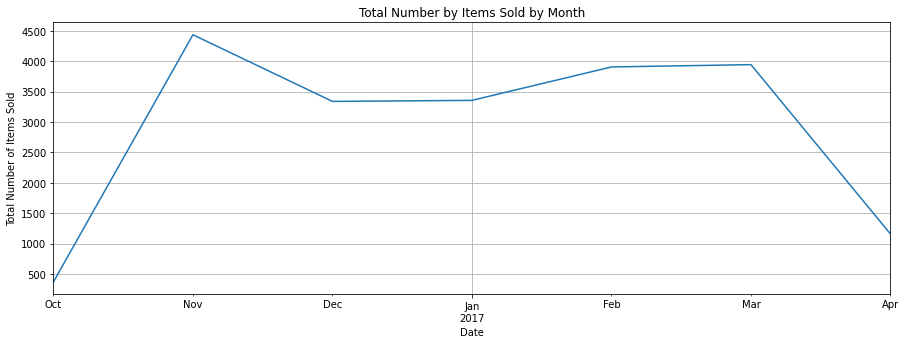

In [ ]:
# Number of items sold by month
bread["Item"].resample("M").count().plot(figsize=(15,5), grid=True, title="Total Number by Items Sold by Month").set(xlabel="Date", ylabel="Total Number of Items Sold")
plt.show()

           Item
Hour           
1      0.006289
7      0.150943
8      4.056604
9     12.364780
10    16.767296
11    19.509434
12    17.949686
13    16.459119
14    16.603774
15    13.301887
16     8.446541
17     2.314465
18     0.515723
19     0.301887
20     0.138365
21     0.018868
22     0.050314
23     0.018868


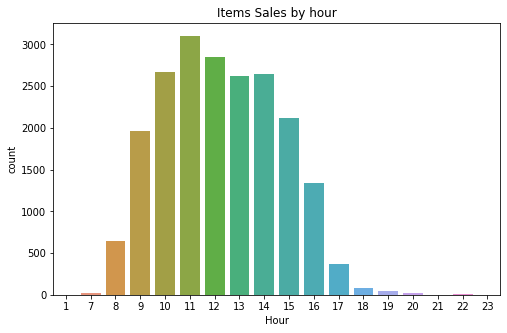

In [ ]:
# Aggregate item sold by hour
bread_groupby_hour = bread.groupby("Hour").agg({"Item": lambda item: item.count()/total_days})
print(bread_groupby_hour)

# Plot items sold by hour
plt.figure(figsize=(8,5))
sns.countplot(x='Hour',data=bread)
plt.title('Items Sales by hour')
plt.show()

The period of lunch time is when there are more customers in the bakery, giving an opportunity to develop strategy of experimentation and promotions to customers experience new products

         Item
Weekday      
1        2324
2        2392
3        2321
4        2646
5        3124
6        4605
7        3095


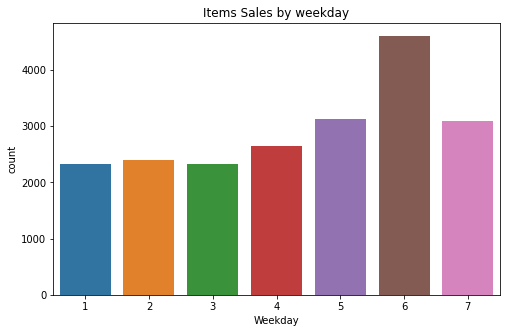

In [ ]:
# sales groupby weekday
bread_groupby_weekday = bread.groupby("Weekday").agg({"Item": lambda item: item.count()})
bread_groupby_weekday.head()
print(bread_groupby_weekday)

# Plot items sold by hour
plt.figure(figsize=(8,5))
sns.countplot(x='Weekday',data=bread)
plt.title('Items Sales by weekday')
plt.show()

In [ ]:
# but we need to find out how many each weekday in that period of transaction
# in order to calculate the average items per weekday

import datetime 
daterange = pd.date_range(datetime.date(2016, 10, 30), datetime.date(2017, 4, 9))

monday = 0
tuesday = 0
wednesday = 0
thursday = 0
friday = 0
saturday = 0
sunday = 0

for day in np.unique(bread.index.date):
    if day.isoweekday() == 1:
        monday += 1
    elif day.isoweekday() == 2:
        tuesday += 1
    elif day.isoweekday() == 3:
        wednesday += 1
    elif day.isoweekday() == 4:
        thursday += 1        
    elif day.isoweekday() == 5:
        friday += 1        
    elif day.isoweekday() == 6:
        saturday += 1        
    elif day.isoweekday() == 7:
        sunday += 1        
        
all_weekdays = monday + tuesday + wednesday + thursday + friday + saturday + sunday

print("monday = {0}, tuesday = {1}, wednesday = {2}, thursday = {3}, friday = {4}, saturday = {5}, sunday = {6}, total = {7}".format(monday, tuesday, wednesday, thursday, friday, saturday, sunday, all_weekdays))

monday = 21, tuesday = 23, wednesday = 23, thursday = 23, friday = 23, saturday = 23, sunday = 23, total = 159


In [ ]:
# apply the conditions to calculate the average items for each weekday
conditions = [
    (bread_groupby_weekday.index == 1),
    (bread_groupby_weekday.index == 2),
    (bread_groupby_weekday.index == 3),
    (bread_groupby_weekday.index == 4),
    (bread_groupby_weekday.index == 5),
    (bread_groupby_weekday.index == 6),
    (bread_groupby_weekday.index == 7)]

choices = [bread_groupby_weekday.Item/21, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23]

bread_groupby_weekday["Average"] = np.select(conditions, choices, default=0)
bread_groupby_weekday

,Item,Average
Weekday,,
1,2324,110.666667
2,2392,104.000000
3,2321,100.913043
4,2646,115.043478
5,3124,135.826087
6,4605,200.217391
7,3095,134.565217


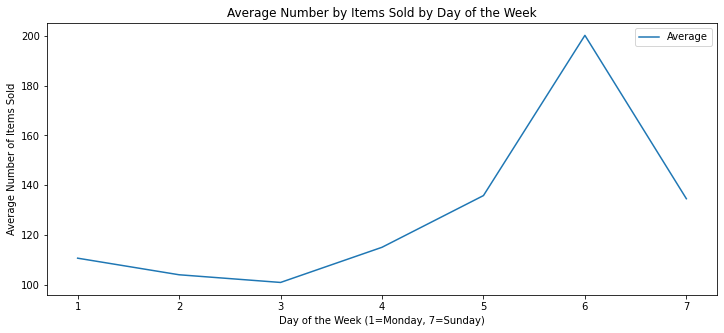

In [ ]:
bread_groupby_weekday.plot(y="Average", figsize=(12,5), title="Average Number by Items Sold by Day of the Week").set(xlabel="Day of the Week (1=Monday, 7=Sunday)", ylabel="Average Number of Items Sold")
plt.show()

As weekend shows to be the best days of sales, the bakery can produce more in those days and reduce in the others days. Another strategy is giving to the customer the perception that there are promotions in other days to increase the visit of the customer to the bakery to check what kind of promotion exists making the average sales during the weekdays increase

**Preparing the dataset to Machine Learning**

In [118]:
# Define dataset to machine learning
df_basket = bread.groupby(["Transaction","Item"]).size().reset_index(name="Count")

market_basket = (df_basket.groupby(['Transaction', 'Item'])['Count'].sum().unstack().reset_index().fillna(0).set_index('Transaction'))
market_basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,Fudge,Gift voucher,Gingerbread syrup,Granola,Hack the stack,Half slice Monster,Hearty & Seasonal,Honey,Hot chocolate,Jam,Jammie Dodgers,Juice,Keeping It Local,Kids biscuit,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
# Convert all of our numbers to either a 1 or a 0 (negative numbers are converted to zero, positive numbers are converted to 1)
def encode_data(datapoint):
  if datapoint <= 0:
    return 0
  else:
    return 1

In [ ]:
# Process the transformation into the market_basket dataset
market_basket = market_basket.applymap(encode_data)

# Check the result
market_basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,Fudge,Gift voucher,Gingerbread syrup,Granola,Hack the stack,Half slice Monster,Hearty & Seasonal,Honey,Hot chocolate,Jam,Jammie Dodgers,Juice,Keeping It Local,Kids biscuit,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



**Building the Apriori model**

Support:

   refers to the default popularity of an item and can be calculated by finding number of transactions containing a particular item divided by total number of transactions

Confidence:
        
  refers to the likelihood that an item B is also bought if item A is bought. It can be calculated by finding the number of transactions where A and B are bought together, divided by total number of transactions where A is bought

Lift:
        
  refers to the increase in the ratio of sale of B when A is sold. Lift(A –> B) can be calculated by dividing Confidence(A -> B) divided by Support(B)

Leverage:

 computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent

Conviction:

A high conviction value means that the consequent is highly

In [ ]:
# Apriori method request a min_support: Support is defined as the percentage of time that an itemset appears in the dataset.
# Defined to start seeing data/results with min_support of 2%
itemsets = apriori(market_basket, min_support= 0.02, use_colnames=True)

In [ ]:
# Build your association rules using the mxltend association_rules function.
# min_threshold can be thought of as the level of confidence percentage that you want to return
# Defined to use 50% of min_threshold
rules = association_rules(itemsets, metric='lift', min_threshold=0.5)

In [ ]:
# Below the list of products sales combinations
# It can use this information to build a cross-sell recommendation system that promotes these products with each other 
rules.sort_values("lift", ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(Tea),(Cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372
10,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865
27,(Coffee),(Toast),0.478394,0.033597,0.023666,0.049470,1.472431,0.007593,1.016699
26,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
19,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
18,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
21,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
20,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
16,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919
17,(Coffee),(Juice),0.478394,0.038563,0.020602,0.043065,1.116750,0.002154,1.004705


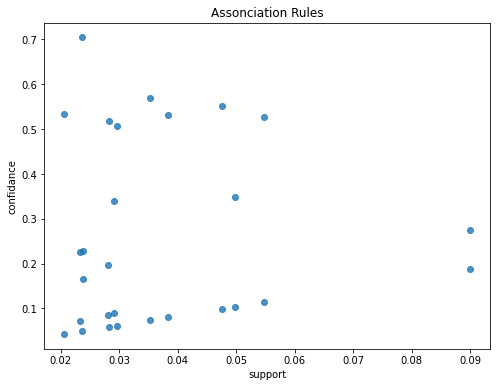

In [ ]:
support = rules.support.to_numpy()
confidence = rules.confidence.to_numpy()

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.figure(figsize=(8,6))    
plt.title('Assonciation Rules')
plt.xlabel('support')
plt.ylabel('confidance')
sns.regplot(x=support, y=confidence, fit_reg=False)
plt.show()

**Recommendations** **filter**

In [ ]:
# Recommendation of Market Basket
rec_rules = rules[ (rules['lift'] > 1) & (rules['confidence'] >= 0.5) ]

In [ ]:
# Recommendation of Market Basket Dataset
cols_keep = {'antecedents':'item_1', 'consequents':'item_2', 'support':'support', 'confidence':'confidence', 'lift':'lift'}
cols_drop = ['antecedent support', 'consequent support', 'leverage', 'conviction']

recommendation_basket = pd.DataFrame(rec_rules).rename(columns= cols_keep).drop(columns=cols_drop).sort_values(by=['lift'], ascending = False)
recommendation_basket['item_1'] = recommendation_basket['item_1'].str.join('()')
recommendation_basket['item_2'] = recommendation_basket['item_2'].str.join('()')
display(recommendation_basket)

,item_1,item_2,support,confidence,lift
26,Toast,Coffee,0.023666,0.704403,1.472431
18,Medialuna,Coffee,0.035182,0.569231,1.189878
21,Pastry,Coffee,0.047544,0.552147,1.154168
16,Juice,Coffee,0.020602,0.534247,1.116750
23,Sandwich,Coffee,0.038246,0.532353,1.112792
8,Cake,Coffee,0.054728,0.526958,1.101515
12,Cookies,Coffee,0.028209,0.518447,1.083723
14,Hot chocolate,Coffee,0.029583,0.507246,1.060311


**Interpretation of recoomendation_basket**

The recommendation_basket selected 8 itemsets sorted by lift > 1, confidence >= 0.5 and support > 1%

The support indicates how many transaction of the itemset (item_1 and item_2) occurs together.

The confidence >= 0.5 indicates that the itemset has the likelihood of the item_2 is bought when someone buys the item_1

The lift shows how item_1 helps to increase the sales of the item_2 when buying those items together

Ex:

Toast and Coffee occurs nearly 2.4% of all transactions (support)
            
The confidence is about 70% showing that the probability to happen this transaction is high

Buying a toast shows that it increase in 47% the probability to buy Coffee showing the influence of Toast over Coffee.

So with the recommendation_basket the team (leader and employees) can be aligned to develop strategies and training to incentive customers who buys item_1 to include the item_2, doing a cross-selling and increasing the store's revenue.



***In the above we have performed data visualization and predicted which item is having more sales. ***

# **So,we got to know Coffee is the most selling product**


I have focused on keeping top 9 best-selling products and products with longer lifespan. Items that have shorter lifespan will be discounted after rush hours at 5 p.m.

I will evaluate and generate new marketing plan to attract more segments of customers. One possible marketing strategy is to implement first-time customer program.

I have need to prepare more items on Fridays, Sundays, and especially Saturdays. Also, It is better to go with risk-taker approach by preparing more items in the store every day, since we are going to do some serious marketing from now on.

I have need to prepare for rush hours from 7 a.m. to 5 p.m., especially 9 a.m. to 3 p.m.

I will optimize our bakery sales by making Food \& Beverage dicounts, e.g. for Bread-Tea and Coffee-Cookies combination. Also, we should consider making family packages and discounts.


In [120]:


import numpy as np # linear algebra
import matplotlib.pyplot as plt # to make plots
plt.rcParams.update({'font.size': 14}) # to change plots' font size

import seaborn as sns # statistical data visualization
import pandas as pd # data processing, I/O csv using pd.read_csv()
import warnings
warnings.filterwarnings("ignore") # hide warnings

df = pd.read_csv('/BreadBasket_DMS.csv') # importing csv file
df.head() # showing first five entries

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [121]:
df.duplicated().value_counts()

False    19640
True      1653
dtype: int64

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


In [123]:
df['Item'].value_counts().sort_values(ascending=False).to_frame()

,Item
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
NONE,786
Sandwich,771
Medialuna,616
Hot chocolate,590
Cookies,540


In [124]:
sums = df['Item'].value_counts().sum()
print(f'Total number of item is {sums}')

Total number of item is 21293




We found that there are 95 distinct products and the total number of item is 21293, with some items only sold once.

Since it is going to be hard to analyze everything, we are going to focus on the most relevant data, that is the top 10 best-selling products in the shop


In [125]:
df['Item'].value_counts().sort_values(ascending=False).to_frame().head(10)

,Item
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
NONE,786
Sandwich,771
Medialuna,616
Hot chocolate,590
Cookies,540




We found that there is NONE item with 786 transactions. Possibly it is because someone cancelled the order after the data was put on the computer. In the next part, we are going to deal with this item.

Nevertheless, we can focus our attention to the top 10 best-selling products as our most relevant data


**3. Preprocessing**

In [126]:
df= df[ df['Item'] != 'NONE' ] # deleting entries with 'Item' == 'NONE'

df['Item'].value_counts().sort_values(ascending=False).to_frame().head(10)

,Item
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
Sandwich,771
Medialuna,616
Hot chocolate,590
Cookies,540
Brownie,379


We managed to delete entries with NONE, now we are going to aggregate remaining less popular products starting from Brownie into one category, Others

In [127]:
Item_count = df['Item'].value_counts()
other = Item_count[Item_count <= 379 ] # Brownie count is 379
df['Item'] = df['Item'].replace(other.index, 'Others')

del Item_count

df['Item'].value_counts().sort_values(ascending=False).to_frame().head(10)

,Item
Others,5878
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
Sandwich,771
Medialuna,616
Hot chocolate,590
Cookies,540


Now, we are going to turn the datatype of column Date to datetime64[ns] to make it easier to analyze.

In [128]:
df['Date'] = df['Date'].astype('datetime64[ns]')


 **4.Analysis**

For the analysis, we will start from the most general analysis into the more specific ones.

We will focus on determining the best business plans from knowing:

    top 10 most selling items
    trend of total transactions overtime
    comparison of sales between days in the week
    the busiest hours for the bakery
    number of items that are bought in a single transaction
    items that are usually bought together

**4.1. Business plan from knowing 10 most selling items**

Our normalized top 10 most selling items are shown in the barplot below.


We can see thatOthers (more than 80 irrelevant items combined) are the most selling items, taking almost one-third of all the transactions. However, it is not easy to determine the specific item that customer will buy at a particular moment. This is because the specific item only contributes less than 2.5% from the total sales.


In real business situation, we generally want to avoid overstocking. In this case, we want to avoid it especially because quality of food items decrease overtime.


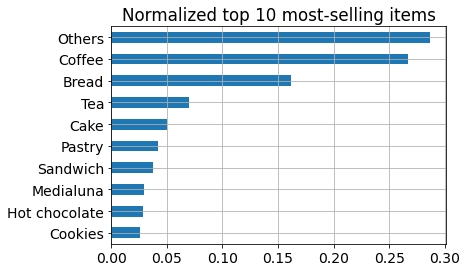

In [129]:
fig = df['Item'].value_counts(normalize=True).sort_values().to_frame().plot(kind='barh',
                                                              title='Normalized top 10 most-selling items',
                                                             grid=True, legend=False)



There are two extreme solutions to this problem:

    We stop buying items in Others and give relevant substitutes to our customer from our top 10 items
    We maximize our customers' satisfaction by keep buying all items in Others

However, as you can guess, these two solutions are not the best solution. We need to optimize between these options.

One way to optimize is by looking at another items in Others. For example, take 4 items then consider their expiration time and adequacy of substitution from the top 9 items


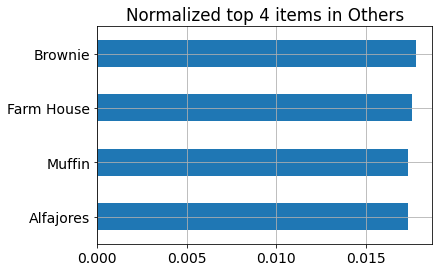

In [130]:


other.head(4).div(sums).to_frame().plot(kind='barh', title='Normalized top 4 items in Others', grid=True, legend=False)
plt.gca().invert_yaxis()





For example, let us look at our top 4 items in Others:

    Brownie: according to this source,

    Store cut brownie squares in an airtight container at room temperature; they're best eaten within 1 to 2 days.

Thus, it might be not economical to stock Brownie, especially because they are sold less than 2% of the time. Another strategy is to stock freshly baked Brownie everyday and give it a discount after rush hours end

    Farm House: according to this source,

    Cornish Farmhouse Frozen Foods Ltd was founded in 1974. The company's line of business includes the wholesale distribution of packaged quick-frozen vegetables, juices, meats, fish, and other deep freeze products.

Frozen foods are known to have long expiration date. And so, though the demand was quite low, it is okay to keep Farm House food in stock just in case.

    Muffin: according to this source,

    Properly stored, freshly baked muffins will last for about 1 to 2 days at normal room temperature.

Thus, it might be better if we can substitute the demand for Muffin to other items. Luckily, Cookie or Brownie can be a good substitute for Muffin. Therefore, we can discontinue Muffin from the store without losing too many customers.

    Juice: We know that Farm House distributes packages of frozen juices. Most fruits can go bad quickly so it is better if we substitute Juice by using Farm House frozen juices.

We can continue this analysis for more items in Others if we want to

**4.2. Business plan from knowing trend of total transaction overtime**

Our number of transactions per day is shown below.

We can see that there are no significant increases nor decreases in the number of transactions. Since we only have less than 6 months of data, it is also unclear whether these systematic ups and downs happen due to season or not.

This rather moderate trend signifies that our customers come to our store regularly, but the number of customers doesn't increase either. If this situation happens in our store, it is better to check our marketing methods. It is possible that our marketing methods were not as effective as it should be and we should focus our resources to reach the market. For example, we can develop a first-time customer program to attract new customers.

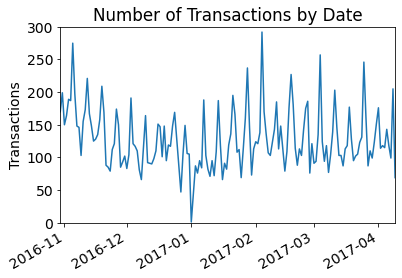

In [131]:
transaction_time_series = df['Date'].value_counts().to_frame().sort_index()
fig = transaction_time_series.plot(kind='line', legend=False, title='Number of Transactions by Date',
                                  ylabel='Transactions')
fig.set_xlim(pd.Timestamp('2016-10-30'), pd.Timestamp('2017-04-09'))
fig.set_ylim(0, 300)
plt.show()

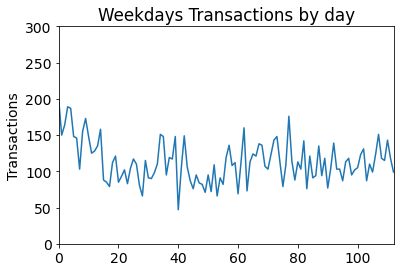

In [132]:
transaction_time_series_weekdays = transaction_time_series [ transaction_time_series.index.dayofweek.isin([0,1,2,3,4]) ]
transaction_time_series_weekdays = transaction_time_series_weekdays.reset_index()
fig = transaction_time_series_weekdays['Date'].plot(kind='line', legend=False, title='Weekdays Transactions by day',
                                  ylabel='Transactions')
fig.set_xlim(0, 112)
fig.set_ylim(0, 300)
plt.show()

**4.3. Business plan from knowing the comparison of transactions between days in the week**

Boxplot of transactions grouped by days is shown below.

We can see that there are no significant differences between weekdays except for Fridays. Most likely it happens because Fridays come before weekends and many people spend their money for snacks at Fridays. Therefore, we need to increase our stock on Fridays compared to other weekdays.

Weekends are good opportunity to increase our sales because we can see that there are more transactions per day on Weekends compared to weekdays. Also, we can see that Saturdays have the highest average transactions per day of all. However, we need to take account of the spread for a particular day. For example, although Saturdays have the highest average sales per day, Saturdays also have the widest spread for transactions per day of all. These spread may cause our transactions prediction to be inaccurate and some items left unpurchased.

There are, again, two extreme approaches to this problem:

Cautious approach: we make a safer choice by setting items equal to the median


Risk taker approach: we take risks by producing items more than the median sales by adding a fraction of spread (measured by interquartile range) on that specific day

Since our bakery will be doing some marketing from now on (from previous Analysis 4.2.), it is generally better to take some risk

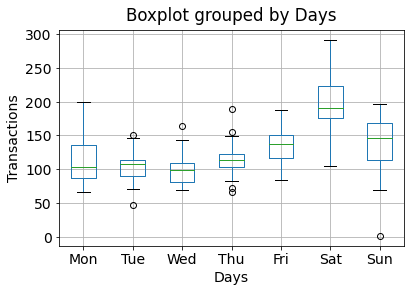

In [133]:


transaction_time_series['Days'] = transaction_time_series.index.dayofweek
transaction_per_day = transaction_time_series.set_index('Days')
transaction_per_day = transaction_per_day.rename(columns={'Date':'Transaction'})
transaction_per_day = transaction_per_day.reset_index()
fig = transaction_per_day.boxplot(by='Days', column=['Transaction'])
plt.title('')
plt.xticks([1,2,3,4,5,6,7], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Transactions')
plt.show()




  **4.4. Business plan from knowing the busiest hours in the bakery**

Histogram of transactions grouped by time of the day is shown below.

We can see that most transactions happen between 7 a.m. to 5 p.m. Also, there are few transactions happen after 7 p.m. From this information, we can optimize our work hours. For example, we can close our store earlier at around 7 p.m. without losing too many customers.

I also mentioned about giving discounts after rush hours in Analysis 4.1. From knowing the transaction hours, we can give discounts to items with shorter expiration dates after the rush hours. It is important to avoid giving discounts in rush hours because we might lose some revenue. In this case, we can try putting discounts for short-lived items (e.g. Bread, Pastry, Brownie) after 5 p.m. This way, we can also attract another type of customers (the discount hunters) that usually don't buy items in our store.

Lastly, it is important to know that the peak of rush hours happen in around 11 a.m. If our marketing plan from Analysis 4.2. succeed, it is possible that situation in the store around 11 a.m. gets very busy and we might need to hire part-time staffs from 11 a.m. to 3 p.m.


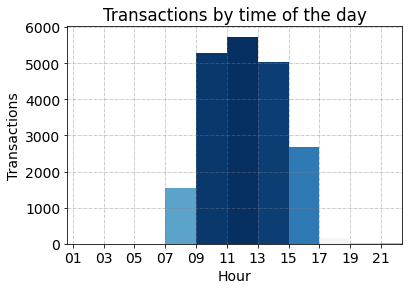

In [134]:
import matplotlib.colors as colors
import matplotlib.dates as mdates
timehist = pd.to_datetime(df['Time'],format="%H:%M:%S")
fig, ax = plt.subplots(1,1)
#create histogram, get bin position for label
N, bins, patches = ax.hist(timehist, bins = 11, facecolor='blue')
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.RdBu(norm(thisfrac))
    thispatch.set_facecolor(color)
#set xticks at bin edges
plt.xticks(bins)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.8)
plt.xlim(pd.to_datetime(-2208985200, unit='s'), pd.to_datetime(-2208906000, unit='s'))
plt.title('Transactions by time of the day')
plt.ylabel('Transactions')
plt.xlabel('Hour')
plt.show()

**4.5. Business plan from knowing number of items bought in single transactions**

Number of items in one transaction and a more detailed stacked barplot is shown below.

We can see that the most frequent number of items sold in one transaction is one. This is not good for various reasons. The first reason is we miss the opportunity of getting more revenue from one transaction, here's why. Generally most people need to eat and drink, so it is quite unusual to buy any food without buying any beverage or vice versa. We can encourage those people who only buy one item in a transaction to spend more by making food and beverage combination discounts. That way, we can get more revenue from the same person. However, we need to watch out because food and beverage combinations are the most popular combination if someone buys two items in one transaction. We need to manage the amount of discount so we get more revenue in total.

That food and beverage combination discount will also be effective for the exact same reason. Since most of our customers who buy more than one item generally buy food and beverage, our appropriate promotion should make them more happy and hence increases their loyalty to our store.

We can also see that only a little fraction of our transaction has more than three items. Generally this means it is quite unusual for a family to visit our store. This insight can be used when we are evaluating and thinking about marketing strategies from Analysis 4.2. For example, we can create packages and discounts for families. That way, we can increase transactions that have more number of items.

Curiously, for two and three items in one transaction, combination of beverage and others are unexpectedly high. We remember that we determined Others quite arbitrarily by aggregating non-top 9 items. It is quite easy to include more items before aggregating the remaining items into Others. However, we will not pursue it any further for now. Just keep in mind that we can always include more items in our pre-processing steps.

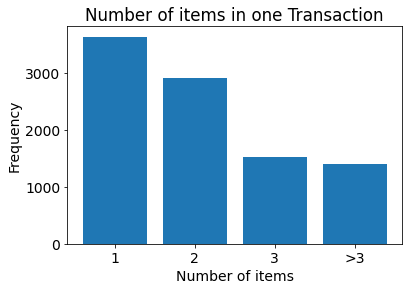

In [135]:
count_transaction = df.groupby(['Transaction']).cumcount() + 1
counts = count_transaction.to_frame().value_counts().to_numpy()

plt.bar(['1','2','3','>3'], [counts[0]-counts[1], counts[1]-counts[2],
                                  counts[2]-counts[3], counts[3]])
plt.title('Number of items in one Transaction')
plt.ylabel('Frequency')
plt.xlabel('Number of items')
plt.show()

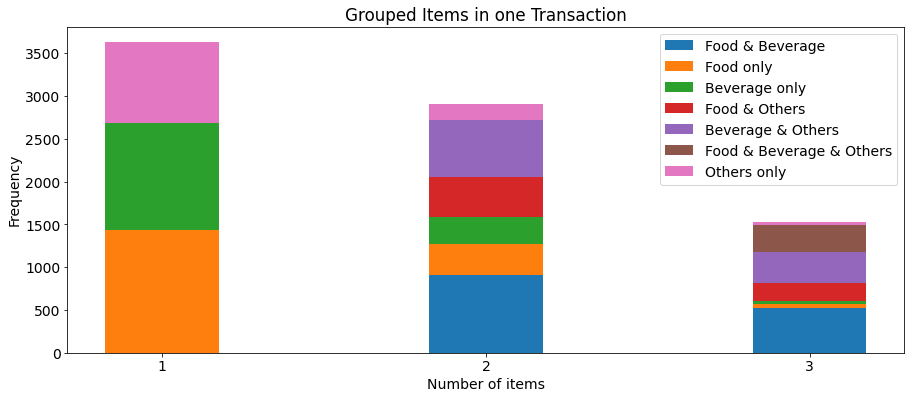

In [136]:
item_map = {'Coffee':3, 'Bread':2, 'Tea':3,
           'Cake':2, 'Pastry':2, 'Sandwich':2,
           'Medialuna':2, 'Hot chocolate':3, 'Cookies':2, 'Others':5}
df['mapped'] = df[['Item']].applymap(item_map.get)
trans_map = df.groupby('Transaction')['mapped'].prod().value_counts()

labels = ['1','2','3']
beverage_only = np.array([trans_map.loc[3], trans_map.loc[9], trans_map.loc[27]])
food_only = np.array([trans_map.loc[2], trans_map.loc[4], trans_map.loc[8]])
food_beverage_mixed = np.array([0, trans_map.loc[6], trans_map.loc[12]+trans_map.loc[18]])
others_only = np.array([trans_map.loc[5], trans_map.loc[25], trans_map.loc[125]])
food_others_mixed = np.array([0, trans_map.loc[10], trans_map.loc[20]+trans_map.loc[50]])
beverage_others_mixed = np.array([0, trans_map.loc[15], trans_map.loc[45]+trans_map.loc[75]])
food_beverage_others = np.array([0, 0, trans_map.loc[30]])
width = 0.35

plt.figure(figsize=(15,6))
plt.bar(labels, food_beverage_mixed, width, label='Food & Beverage')
plt.bar(labels, food_only, width, bottom=food_beverage_mixed, label='Food only')
plt.bar(labels, beverage_only, width, bottom=food_only+food_beverage_mixed, label='Beverage only')
plt.bar(labels, food_others_mixed, width, bottom=food_only+food_beverage_mixed+beverage_only,
        label='Food & Others')
plt.bar(labels, beverage_others_mixed, width, bottom=food_only+food_beverage_mixed+beverage_only+food_others_mixed,
        label='Beverage & Others')
plt.bar(labels, food_beverage_others, width, bottom=food_only+food_beverage_mixed+beverage_only+food_others_mixed+beverage_others_mixed,
        label='Food & Beverage & Others')
plt.bar(labels, others_only, width, bottom=food_beverage_others+food_only+food_beverage_mixed+beverage_only+food_others_mixed+beverage_others_mixed,
        label='Others only')

plt.xlabel('Number of items')
plt.ylabel('Frequency')
plt.title('Grouped Items in one Transaction')
plt.legend()

plt.show()


**4.6. Business plan from knowing items that are generally bought together**

Let's take a closer look for Food \& Beverage combination when two items are bought at the same time. This is a more detailed view on bottom bar for two items in one transaction from the upper figure.

As expected, Bread-Coffee combination is the most frequent combination of all. However, it's not preferable to give discount to that particular combination since it will reduce our profit. Generally, it's better to pair our popular products with less popular ones. For example, we can see in the figure below that Bread (our most popular food) can go quite well with Tea, while Coffee (our most popular beverage) can go quite well with Cookies.

# ** Therefore, it is a viable option to give discounts to Bread-Tea and Coffee-Cookies combination.** 
This way, as mentioned in **Analysis 4.5.**, we hope to reduce single-item-purchase in one transaction by encouraging them to spend more on discounted combinations and get more revenue from the customers.


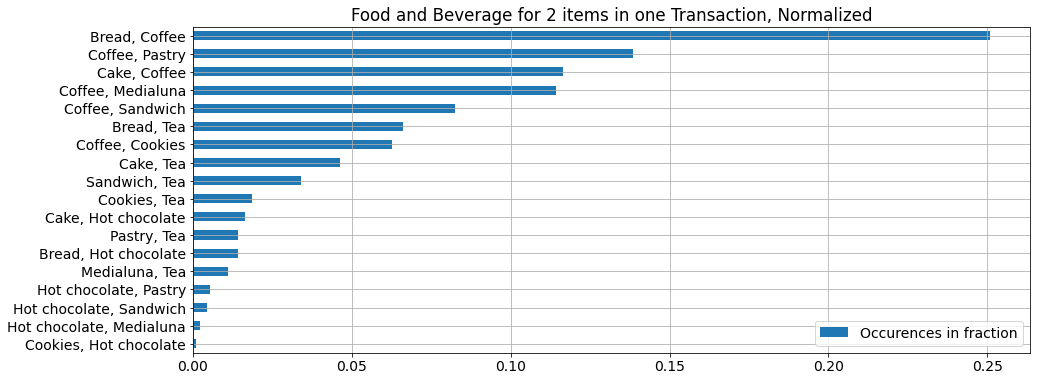

In [137]:
from collections import Counter

group = []
food_beverage_group_pre = []
food_beverage_group = []

groups = df.groupby('Transaction')['Item'].agg(list).to_frame()
for i in groups['Item']:
    member = list(dict.fromkeys(i))
    group.append(member)
    
trans_group = df.groupby('Transaction')['mapped'].prod()
for i in range(len(trans_group)):
    if trans_group.iloc[i] == 6:
        food_beverage_group_pre.append(group[i])

for t in food_beverage_group_pre:
    t.sort()
    food_beverage_group.append(', '.join(map(str, t)))
    
food_beverage_occurence = dict(Counter(food_beverage_group))

del food_beverage_group_pre
del food_beverage_group

food_beverage_occurence = pd.DataFrame.from_dict(food_beverage_occurence, orient='index', columns=['occurence'])
food_beverage_occurence.div(trans_map.loc[6]).sort_values('occurence').plot(kind='barh', figsize=(15,6), grid=True)
plt.title('Food and Beverage for 2 items in one Transaction, Normalized')
plt.legend(['Occurences in fraction'], loc='lower right')
plt.show()

**5. Conclusion**

By analyzing the dataset, we conclude that the best business plans for this bakery are:

We focus on keeping top 9 best-selling products and products with longer lifespan. Items that have shorter lifespan will be discounted after rush hours at 5 p.m.


We will evaluate and generate new marketing plan to attract more segments of customers. One possible marketing strategy is to implement first-time customer program.


We need to prepare more items on Fridays, Sundays, and especially Saturdays. Also, It is better to go with risk-taker approach by preparing more items in the store every day, since we are going to do some serious marketing from now on.


We need to prepare for rush hours from 7 a.m. to 5 p.m., especially 9 a.m. to 3 p.m.

We can optimize our bakery sales by making Food \& Beverage dicounts, e.g. for Bread-Tea and Coffee-Cookies combination. Also, we should consider making family packages and discounts.

# **And Coffee is the most selling product form the visulization**

# Questions to be answered -

**1. Combination of which 2 items will increase the sales on a regular basis?**

**Answer :**

Bread-coffee


**2. At what time of the day are the sales most influential? (consider the complete data for answering this question)**

**Answer :**

Rush hours from 7 a.m. to 5 p.m., especially 9 a.m. to 3 p.m.
and most costomers visit is in between 11Am-12Pm.

Weekends and Friday also many people spend their money for snacks at Fridays. Therefore, we need to increase our stock on Fridays compared to other weekdays. 


**3. If you had to replace an item from the servings, which would it be and why?**

**Answer:**

Thus, it might be better if we can substitute the demand for Muffin to other items. 

Luckily, Cookie or Brownie can be a good substitute for Muffin. 

Therefore, we can discontinue Muffin from the store without losing too many customers.


**4. If you had to add wine to one particular hour of the day, at what time would it be?**

**Answer :** 

It is best to add wine on 11:00 AM -12:00 PM as the visit of coustomer is high .and marketing of new product can be in more efficient way and attract more coustmers at that time since there will be more number of people will be known about this product.

